# Yandex Zen

# Table of contents

I. General information. Interim conclusions.    

II. Data preprocessing.

- Changing the data type.
- Categorical data processing
- Numerical data processing
- Duplicates processing

III. Conclusion.

In [1]:
# libraries import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine

In [2]:
# seaborn customization
sns.set_style(rc={'axes.facecolor':'28343a'})
sns.set_palette('Reds')

In [3]:
# matplotlib customization
plt.rcParams['figure.figsize'] = (20,5)

Displaying tables with borders:

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
# conncetion to database
db_config = {'user': 'user', 
            'pwd': 'pwd', 
            'host': 'host',
            'port': 0000, 
            'db': 'data-analyst-zen-project-db'} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string) 

In [6]:
# query execution
query = 'SELECT * FROM dash_visits'
data = pd.io.sql.read_sql(query, con = engine) 

# General information

In [7]:
# reading the file and saving it to the 'data' variable
pth = '/home/yuso/jupyter_dir/jupyter_env/datasets/dash_visits_eng.csv'
if os.path.exists(pth):
    data = pd.read_csv(pth)
else:
    print('Something is wrong')

In [8]:
# primary data analysis function
def get_info(df):
    '''The function takes a dataframe as an input and provides general information about it: its shape (rows, columns),
    columns data type, number of non-null values (DataFrame.info()), first\last five rows (DataFrame.head()\tail()) and also a
    brief analysis for categorical and numerical data - DataFrame.describe().'''
    percentiles= [.20, .40, .60, .80]
    include=['object', 'float', 'int']
    print(f'Total number of rows: {df.shape[0]}, total number of columns: {df.shape[1]}.')
    print()
    print(df.info())
    display(df.head())
    display(df.tail())
    display(pd.DataFrame(df.describe(percentiles = percentiles, include = include).T))

In [9]:
# applying get_info function
get_info(data)

Total number of rows: 30745, total number of columns: 6.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   record_id     30745 non-null  int64 
 1   item_topic    30745 non-null  object
 2   source_topic  30745 non-null  object
 3   age_segment   30745 non-null  object
 4   dt            30745 non-null  object
 5   visits        30745 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.6+ MB
None


,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Money,Auto,18-25,2019-09-24 18:32:00,3
1,1040598,Money,Auto,18-25,2019-09-24 18:35:00,1
2,1040599,Money,Auto,18-25,2019-09-24 18:54:00,4
3,1040600,Money,Auto,18-25,2019-09-24 18:55:00,17
4,1040601,Money,Auto,18-25,2019-09-24 18:56:00,27


,record_id,item_topic,source_topic,age_segment,dt,visits
30740,1071337,Humor,Finance,36-40,2019-09-24 18:57:00,2
30741,1071338,Humor,Finance,36-40,2019-09-24 19:00:00,1
30742,1071339,Humor,Finance,41-45,2019-09-24 18:54:00,1
30743,1071340,Humor,Finance,41-45,2019-09-24 18:56:00,1
30744,1071341,Humor,Finance,41-45,2019-09-24 19:00:00,1


,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
record_id,30745.0,NaN,NaN,NaN,1055969.0,8875.46135,1040597.0,1046745.8,1052894.6,1055969.0,1059043.4,1065192.2,1071341.0
item_topic,30745,25,Relationship,1536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_topic,30745,26,Family relationships,1822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_segment,30745,6,18-25,7056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dt,30745,17,2019-09-24 18:58:00,3383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,30745.0,NaN,NaN,NaN,10.089673,19.727601,1.0,1.0,2.0,3.0,5.0,13.0,371.0


In [10]:
# set unique record ID as an index
data.set_index('record_id', inplace=True)

The dataframe has 6 columns (2 of them - int64, 4 - object type) and 30745 rows.

**According to the documentation:**

`record_id` - a unique number to every card;      
`item_topic` - card topic;       
`source_topic` - source topic;          
`age_segment` - visitor's age group;      
`dt` - visit time;            
`visits` - total number of visits;          

**Brief data analysis:**

- there are no missing values in the data;
- data type issues - `dt` column has type object, datetime is needed;
- object_type columns contain 25-26 unique values, we'll find out if there are duplicates;

Each row of the table contains data about a card - its unique ID, item and source topics, age segment and total number of visits. All cards have 25 item topics, 26 source topics and 6 age groups. The most popular topics are relationships, age segment - 18-25.  

It can be argued that currently available data is sufficient for the task. But this data needs to be processed: we need to check and remove duplicates, incorrect values, process numerical and categorical data.

# Data preprocessing

## Changing the data type

In [11]:
# to datetime conversion
data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%d %H:%M:%S')

## Categorical data processing

In this section we will check unique values in card and source topics and create tables with topic ratio. 

In [12]:
# top 10 card topics
data_item = pd.DataFrame(data['item_topic'].value_counts(ascending=False).head(10))
data_item.rename(columns={'item_topic': 'Count'}, inplace=True)
data_item['Ratio'] = data_item['Count']/data.shape[0]
data_item['Ratio'] = data_item['Ratio'].astype(float).map("{:.1%}".format)
data_item

,Count,Ratio
Relationship,1536,5.0%
Interesting Facts,1535,5.0%
Science,1505,4.9%
Collections,1456,4.7%
Helpful Hints,1424,4.6%
Society,1422,4.6%
Russia,1385,4.5%
History,1363,4.4%
Family,1287,4.2%
Travel,1247,4.1%


In [13]:
# top 10 source topics
data_source = pd.DataFrame(data['source_topic'].value_counts(ascending=False).head(10))
data_source.rename(columns={'source_topic': 'Count'}, inplace=True)
data_source['Ratio'] = data_source['Count']/data.shape[0]
data_source['Ratio'] = data_source['Ratio'].astype(float).map("{:.1%}".format)
data_source

,Count,Ratio
Family relationships,1822,5.9%
Russia,1687,5.5%
Celebrities,1650,5.4%
Helpful Hints,1578,5.1%
Travel,1563,5.1%
Movie,1505,4.9%
Children,1459,4.7%
History,1437,4.7%
Family,1405,4.6%
Clothing,1379,4.5%


## Numerical data processing

In this section we'll check min and max observation date, total number of visits and age group distribution.

In [14]:
# observation period
print('Min date:', data['dt'].min())
print('Max date:', data['dt'].max())

Min date: 2019-09-24 18:28:00
Max date: 2019-09-24 19:00:00


In [15]:
# total visits
data['visits'].sum()

310207

In [20]:
# age groups distribution
data_age = pd.DataFrame(data['age_segment'].value_counts(ascending=False))
data_age.rename(columns={'age_segment': 'Count'}, inplace=True)
data_age.T

,18-25,26-30,31-35,36-40,41-45,45+
Count,7056,5875,5552,5105,3903,3254


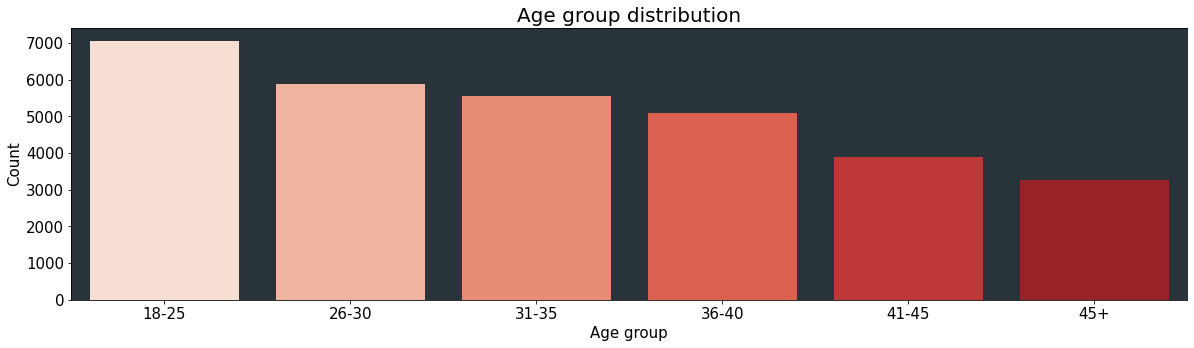

In [17]:
# age groups barplot
sns.barplot(x=data_age.index, y='Count', data=data_age)
plt.title('Age group distribution', fontsize=20)
plt.xlabel('Age group', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15);

## Duplicates processing

In [18]:
# duplicates check
data.duplicated().sum()

0

There are no duplicates in the data.

# Conclusion

The data was processed for a dashboard and presentation.

In [19]:
# processed data saving
data.to_csv(r'C:\Users\maslo\Documents\work\datasets\dash_visits_rem.csv')